In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
%matplotlib inline
from IPython.display import Image

# Bayes Statistik III

# Posterior-Zufallsstichproben (Teil a)
am Beispiel dichotomer Daten

## Ziel
- Stichproben aus dem Posterior gewinnen
- Statistik
    - Punktschätzer, Intervallschätzer 

## Problem
- Mathematisch geschlossene Lösung
    - nicht immer anwendbar
- Numerische Gitter-Berechnung
    - Bayes Schlußfolgern erlaubt Berechnung des Posteriors
    - Benötigt jedoch das Integral *evidence*
        - über alle Parameterkombinationen bei numerischer Berechnung mit hinreichend vielen Stützstellen

        
## Lösung
- Markov Chain Monte Carlo Methode *MCMC*
    - Stichproben aus Posterior-Verteilung

#### Vorgehensweise
- (zufällige aber zielgerichtete und repräsentative) Stichproben (nicht das vollständige Gitter)
    - "Monte Carlo"
    - gemäß der Posterior-Verteilung(!)

#### Voraussetzungen MCMC
- Berechenbarkeit des Priors $p(\theta)$
    - für jeden Parameter $\theta \in \mathbb{R}$
- Berechenbarkeit der Likelihood $p(D|\theta)$
    - für jedes Datum $D$ und jeden Parameter $\theta$

#### Vorteil
- Dafür kann die evidence (Normierung, Skalierungsfaktor) übergangen werden

## Ergebnis
- Posterior $p(\theta|D)$ Stichproben
- Daraus Abschätzen
    - Erwartungswert *Mean Posterior*
    - Modus *Maximal A Posterior* (MAP)
    - *Credibility-Intervall* (CI) oder *Highest Density Interval* (HDI)

#### Beachten
- Keine p sollen exakt Null sein, sonst Zu-/Durchgang schwierig

#### Beweis (später)
- Transformationsmatrix ist unter der Ziel-Verteilung stabil

# Vereinfachter Metropolis-Algorithmus
- diskrete Möglichkeiten
- Parameter $\theta$
    - eindimensional
    - Wahrscheinlichkeit $p(\theta)$
- konstante Schrittweite: 1

Ein Versicherungsvertreter möchte auf einer Kette von Inseln alle Kunden gleich häufig besuchen
- Jede Insel $\theta \in \{0\dots N\}$ hat einen Bevölkerungsanteil $p(\theta)$
- Per Blick ist abends abzuschätzen, wie viel höher der Bevölkerungsanteil auf einer der beiden Nachbarinseln ($\theta-1$ bzw. $\theta+1$) ist
- Am Morgen wird (wenn lohnenswert) eine Nachbarinsel besucht

#### 1. Richtungsentscheidung
Wähle zufällig (mit Wahrscheinlichkeit $50\%$) rechte oder linke Insel $\theta$ aus<br>
$\Rightarrow\;$ Dies liefert den *Kandidaten*.
$$\theta_{\mathrm{Kandidat}} = \begin{cases} \theta_{\mathrm{aktuell}}-1\\ \theta_{\mathrm{aktuell}}+1\end{cases}$$

#### 2. Sprung-Wahrscheinlichkeit
a) Wenn $p(\theta_\text{Kandidat}) > p(\theta_\text{aktuell})$ dann gehe zu Kandidat
$$q=1$$

b) Wenn $p(\theta_\text{aktuell}) \geq p(\theta_\text{Kandidat})$ dann gehe proportional zum Wahrscheinlichkeits(dichte)-Verhältnis zum Kandidaten
$$q=\frac{p(\theta_\text{Kandidat})}{p(\theta_\text{aktuell})}$$

c) sonst bleibe
$$q=1-\frac{p(\theta_\text{Kandidat})}{p(\theta_\text{aktuell})}$$

#### (3. Keine Berechnung der *evidence* nötig)

## Ergebnis:
- Kette von Sprüngen "Markov Chain"
- Wahrscheinlichkeit der Aufenthalte $\equiv$ Wahrscheinlichkeit der Punkte $p(\theta)$
- funktioniert

In [3]:
'''Metropolis algorithm - A) initialze'''
N = 20                                    # different possible values of... 
thetas = np.linspace(0., 1., N+1)         #   ... parameter theta
a, b = (3+1, 7+1)
ptheta = stats.beta(a, b).pdf(thetas)     #   ... and its distribution
np.random.seed(987654)                    # random, but initialized same

def hoptest(current, proposed):
    '''compare probability of proposed versus current parameter theta
       calculate likelihood   (current and proposed)
                 prior        (current and proposed)
                "posteriors"  = likelihood*prior; but not normalized
                 probability  = posterior_proposed/posterior_current
                              limit to 1 if proposed bigger: definitely jump
       returns   probability for "perform jump"  0<=q<=1'''
    return min(1., ptheta[proposed] / ptheta[current])

In [4]:
'''start random walk and step forward according to probability q'''
index = 2                  # start position (in principle random)
twalk = [thetas[index]]    # ... as first value of walk list
n = 5000

for j in range(n):                           # walk through the theta-distribution
    if stats.bernoulli(.5).rvs():            # direction 50:50; --- 1=step forward
        if index>=N:                         # end of indices
            step = 0                         # do not jump; don't change t-index
        else:
            step = stats.bernoulli(hoptest(index, index+1)).rvs()     # +1 or 0
    else:                                    # direction        --- 0=step backward
        if index<=0:                         # first of indices
            step = 0                         # do not jump; don't change t-index
        else:
            step = -stats.bernoulli(hoptest(index, index-1)).rvs()    # -1 or 0
    index += step                            # update index according to move direction
    theta = thetas[index]                    # new theta (proposed or current, depending on step)
    twalk += [theta]                         # add this step to the random walk list

# twalk, all the steps, should be proportional to the probability of the distribution
print('the walk went {} steps'.format(len(twalk))) 

the walk went 5001 steps


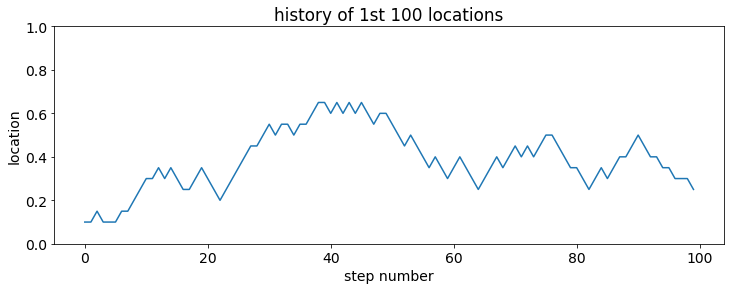

In [5]:
'''show first 100 steps'''
nfirst = 100
fig = plt.figure(figsize=(12, 4))
plt.plot(twalk[:nfirst])
plt.title('history of 1st {} locations'.format(nfirst))
plt.xlabel('step number')
plt.ylabel('location')
plt.ylim((0, 1));

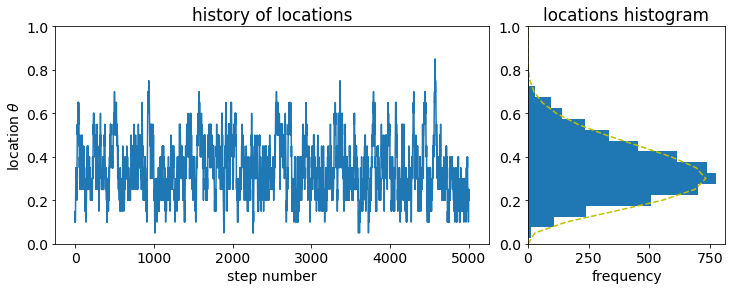

In [6]:
'''show complete Metropolis walk (5000 steps) together with distribution of locations'''
fig = plt.figure(figsize=(12, 4))
fwalk = plt.subplot2grid((1, 3), (0, 0), colspan=2)       # upper marginal 3x1, until 3rd column
fwalk.set_ylim((0, 1))
fwalk.plot(twalk)
fwalk.set_title('history of locations')
fwalk.set_xlabel('step number')
fwalk.set_ylabel('location $\\theta$')
fhist = plt.subplot2grid((1, 3), (0, 2))                  # right marginal 1x3, start 2nd row, last col
fhist.hist(twalk, bins=np.linspace(0., 1., N+1), orientation='horizontal', align='left')
fhist.set_ylim((0, 1))                                    # histogram of marginal
fhist.set_xlabel('frequency')
fhist.set_title('locations histogram')
fhist.plot(ptheta*n/N, thetas, 'y--');                    # compare to theoretical distribution

## 1. Ergebnis
- Stichprobe aus der Wahrscheinlichkeits-Verteilung
    - für den Parameter $\theta$ 
    - (nicht für Daten!)
- Erwartungswert
    - Mittelwert
- Modus: MAP
    - Histogramm
    - KDE
    - Modell-Anpassung

## Vergleich NHST
- Verteilung von Daten unter Parameter
- Likelihood
- Punktschätzer: Max Likelihood Estimator (MLE)
- Intervallschätzer: Konfidenzintervall
$$ \widehat\mu-t_{1-\alpha/2}(n\!-\!1)\frac{\widehat\sigma}{\sqrt{n}} \;\leq \; \mu \;\leq \;\widehat\mu+t_{1-\alpha/2}(n\!-\!1)\frac{\widehat\sigma}{\sqrt{n}}$$
    - überdeckt zu $1-\alpha$ den wahren Parameter
    - Voraussetzung: Normalverteilte Stichprobe
        - Punkschätzer Erwartungswert $$\widehat\mu = \overline{x}$$
        - Punktschätzer Varianz $$\widehat\sigma^2 = \frac{1}{n-1}\sum_{i=1}^n(x_i-\overline{x})^2$$


In [8]:
from AngStII_Bayes import HDIofGrid
HDIofGrid?

    Signature: HDIofGrid(x, credmass=0.95)
    Docstring:
    calculate HDI of a given distribution for example from histogram[0] output
      input:  pmfvec:   vector of probability masses at each grid point
              credmass: desired mass of the HDI region; default=95%
      returns: a dictionary with components:
              indices:  vector of indices that are in the HDI
              mass:     total mass of the included indices
              height:   smallest component probability mass in the HDI
      Idea: Kruschke book 2015, supplementary R-code
      [This function works for histograms/grids, not distributions]
    File:      ~/VL/statistik/AngStII_Bayes.py
    Type:      function

In [9]:
'''check what HDIofGrid() returns'''
bins=np.linspace(-0.5/N, 1.+.5/N, N+2)
hdiinfo = HDIofGrid(np.histogram(twalk, bins=bins)[0])
print(hdiinfo)

{'indices': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), 'mass': 0.9704059188162367, 'height': 109}


In [10]:
from AngStII_Bayes import HDIofICDF
HDIofICDF?

    Signature: HDIofICDF(dist_name, credmass=0.95, **args)
    Docstring:
    calculate HDI (highest density interval) for prior and posterior
      input: distribution function:  must supply a .ppf() method
             [args]:                 if supplied passed to function; 
                                     none else e.g. for frozen distribution
      https://stackoverflow.com/questions/22284502/highest-posterior-density-region-and-central-credible-region
      trick "minimize width of HDI" after Kruschke R-code to Fig 6.3
      [This function works for distributions, not random variables/grids]
    File:      ~/VL/statistik/AngStII_Bayes.py
    Type:      function

## Ergebnis des Metropolis-Spaziergangs

estim. 95% HDI 0.075-0.625
theor. 95% HDI 0.093-0.588


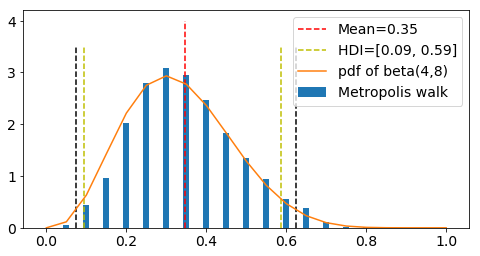

In [11]:
'''result of Metropolis walk: posterior distribution => Mean and HDI'''
fig = plt.figure(figsize=(8, 4))
mean = np.asarray(twalk).mean()       # Estimate of posterior's expectation value 
plt.plot(2*[mean], [0, 4.0], 'r--', label='Mean={:.2f}'.format(mean))
hist = plt.hist(twalk, bins=bins, density=True, label='Metropolis walk', rwidth=.3)
plt.plot(2*[hist[1][hdiinfo['indices'][0]]], [0, 3.500], 'k--')      # start of lower bin
plt.plot(2*[hist[1][1+hdiinfo['indices'][-1]]], [0, 3.500], 'k--')   # end of upper bin    
dposterior = stats.beta(a, b)         # freeze theoretical posterior distribution for easy re-using
bl, bu = HDIofICDF(stats.beta, credmass=0.95, a=a, b=b)
print('estim. 95% HDI {:.3f}-{:.3f}'.format(hist[1][hdiinfo['indices'][0]], hist[1][1+hdiinfo['indices'][-1]]))
print('theor. 95% HDI {:.3f}-{:.3f}'.format(bl, bu))
plt.plot(2*[bl], [0, 3.5], 'y--', label='HDI=[{:.2f}, {:.2f}]'.format(bl, bu))
plt.plot(2*[bu], [0, 3.5], 'y--')
plt.plot(thetas, dposterior.pdf(thetas), label='pdf of beta({},{})'.format(a, b))
plt.legend(loc='upper right');

# Zusammenfassung
- Bayes Statistik: Wissen über Verteilung des Parameters
- Bayes Schlußfolgerung: Verbessern des Wissens (Prior) durch Messung (Daten, Likelihood) $\Rightarrow$ Posterior
- Posterior bestimmen
    - mathematisch-theoretisch durch *conjugate priors*
    - Gitter-Näherung
    - Metropolis-Algorithmus / *Markov Chain Monte Carlo*-Methode (MCMC)
- Auswerten der Posterior-Verteilung
    - Erwartungswert *Mean Posterior*
    - Modus *Maximum A Posteriory* (MAP)
    - *Credible Interval* (CI)
$$p(\theta\in \text{CI})>= 1-\alpha$$

# Literatur
- Kruschke, J. K. (2015): Doing Bayesian Data Analysis, Second Edition. Academic Press / Elsevier


# Zitate

> "I wasted 10 years calculating p-values" (Shravan Vasishth)

----

> "if you have been previously contaminated by NHST, ..."<br>
> "Bayesian analysis yields richer and more informative inferences than NHST" (John K. Kruschke)


# Fragen?